# Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

In [4]:
def rank_tensor(x):
    """
    Returns the ranks of the elements in the input tensor x.
    """
    tmp = x.argsort()
    ranks = torch.zeros_like(tmp)
    ranks[tmp] = torch.arange(len(x), device=x.device)
    return ranks

def spearman_corr(x, y):
    """
    Calculates the differentiable Spearman correlation between two tensors x and y.
    """
    assert x.shape == y.shape, "Input tensors must have the same shape"
    
    n = x.size(0)

    # Rank the tensors
    x_rank = rank_tensor(x).float()
    y_rank = rank_tensor(y).float()
    
    # Compute the covariance between the ranks
    x_rank_mean = x_rank.mean()
    y_rank_mean = y_rank.mean()
    
    cov_xy = ((x_rank - x_rank_mean) * (y_rank - y_rank_mean)).mean()
    
    # Compute the standard deviations of the ranks
    std_x_rank = x_rank.std()
    std_y_rank = y_rank.std()
    
    # Compute the Spearman correlation
    spearman_corr = cov_xy / (std_x_rank * std_y_rank)
    
    return spearman_corr


# Load data

In [5]:
X_A = pd.read_csv('X_Govaere.csv',index_col=0)
X_B = pd.read_csv('X_Kostrzewski_grouped.csv',index_col=0)
Y_A = pd.read_csv('Y_Govaere.csv',index_col=0)
Wh = pd.read_csv('../results/Wh_govaere.csv',index_col=0)
W_extra = pd.read_csv('../results/Wm_kostrzewski_extra.csv',index_col=0)
start_ind = 'high_lean_FALSE_FALSE_FALSE_FALSE'
# lean_control_ind = 'high_lean_FALSE_FALSE_FALSE_FALSE' # in the pair that explains most of the variance it is the control
# fatty_control_ind = 'high_fat_FALSE_FALSE_FALSE_FALSE'

In [6]:
W_extra = pd.read_csv('../results/Wm_kostrzewski_extra.csv',index_col=0)

In [7]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

3569.181344230154


# Get PCA loadings

In [8]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

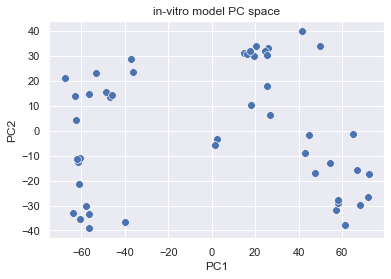

In [9]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [10]:
loadings = pca.components_
print(loadings.shape)

(48, 26001)


In [11]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 32.44 %


# Initialize perturbation as a small random dX

In [12]:
XB_start = X_B.loc[start_ind,:].values.reshape(1,X_B.shape[1])
# XB_lean = X_B.loc[lean_control_ind,:].values.reshape(1,X_B.shape[1])
# XB_fatty = X_B.loc[fatty_control_ind,:].values.reshape(1,X_B.shape[1])
dX = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_start.shape[1]))
dX = torch.tensor(dX).float().to(device)
Input_start = torch.nn.Parameter(dX, requires_grad = True)
Input_start.retain_grad()
optimizer = torch.optim.Adam([Input_start],lr= 0.1,weight_decay=0)
XB_start = torch.tensor(XB_start).float().to(device)
XB_start = torch.mean(XB_start,0,keepdim = True)
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)
W_A = torch.tensor(Wh.values).float().to(device)
W_B_extra = torch.tensor(W_extra.values).float().to(device)
Wm = torch.tensor(pca.components_.T).float().to(device)
W_tot = torch.concat([Wm,W_B_extra],dim=1)
W_tot = W_tot[:,:-1]

In [13]:
Wm.shape

torch.Size([26001, 48])

In [14]:
print(XB_start.shape)

torch.Size([1, 26001])


In [15]:
W_tot.shape

torch.Size([26001, 49])

Sample 0 Iteration=0, loss=48.1023
Sample 0 Iteration=200, loss=-18.1638
Sample 0 Iteration=400, loss=-24.8358
Sample 0 Iteration=600, loss=40.6132
Sample 0 Iteration=800, loss=-47.7176
Sample 0 Iteration=999, loss=-51.4281
[0.9999336  0.9973255  0.9982366  0.9912336  0.9889729  0.6705473
 0.7368659  0.7840855  0.8964049  0.9386755  0.9995961  0.75969803
 0.75921273 0.9614744  0.98603964 0.9999981  0.9999874  0.9996851
 0.9960747  0.9988113  0.9916401  0.98961985 0.9972512  0.9985355
 0.99264    0.9884717  0.99944615 0.9997971  0.9996542  0.9980518
 0.996159   0.9973869  0.9995043  0.9999166  0.99886274 0.9997774
 0.9996015  0.999597   0.9999754  0.99820447 0.99879515 0.99969286
 0.9998424  0.9881862  0.9915566  0.9935777  0.9851875  0.99364215
 0.6934708 ]
0.6705473
Sample 1 Iteration=0, loss=-53.2247
Sample 1 Iteration=200, loss=-54.5887
Sample 1 Iteration=400, loss=-56.2266
Sample 1 Iteration=600, loss=-56.1257
Sample 1 Iteration=800, loss=-56.7809
Sample 1 Iteration=999, loss=-55.7

Sample 11 Iteration=200, loss=-53.9419
Sample 11 Iteration=400, loss=-56.8810
Sample 11 Iteration=600, loss=-55.1256
Sample 11 Iteration=800, loss=-55.9445
Sample 11 Iteration=999, loss=-54.9283
[0.9999102  0.99673057 0.9907508  0.977434   0.98752815 0.72673124
 0.6824747  0.97920495 0.99886787 0.99991304 0.9984349  0.9554275
 0.9575324  0.9965466  0.9972395  0.9999925  0.999788   0.99963635
 0.9989018  0.9999732  0.9977233  0.99774474 0.9999682  0.99982166
 0.9989781  0.99750686 0.99999726 0.99980825 0.9999155  0.9996238
 0.99928635 0.9996959  0.99981153 0.999849   0.9997402  0.9999999
 0.9999447  0.9999528  0.99996257 0.99972796 0.9999333  0.9999842
 0.9999713  0.9953475  0.9971009  0.99767303 0.99567056 0.99838257
 0.69237   ]
0.6824747
Sample 12 Iteration=0, loss=-55.6137
Sample 12 Iteration=200, loss=-56.7954
Sample 12 Iteration=400, loss=-54.5370
Sample 12 Iteration=600, loss=-56.1727
Sample 12 Iteration=800, loss=-55.0994
Sample 12 Iteration=999, loss=-54.4096
[0.9999097  0.9967

Sample 22 Iteration=200, loss=-56.7382
Sample 22 Iteration=400, loss=-54.8627
Sample 22 Iteration=600, loss=-55.8271
Sample 22 Iteration=800, loss=-53.3293
Sample 22 Iteration=999, loss=-55.8865
[0.99990714 0.9966803  0.991515   0.9802107  0.98821354 0.69236153
 0.71818495 0.9757122  0.9982704  0.99986    0.99805367 0.93948245
 0.94041824 0.9951322  0.99659604 0.9999776  0.99973226 0.99952644
 0.9987455  0.99995184 0.9972267  0.99725163 0.9999578  0.9998264
 0.9988606  0.997177   1.         0.99978334 0.9999156  0.99953675
 0.99918777 0.999684   0.999785   0.9997984  0.9996441  0.9999998
 0.99994147 0.9999519  0.99995977 0.9996845  0.9999157  0.9999798
 0.9999807  0.9943245  0.9961476  0.99740416 0.99491256 0.99818146
 0.7009833 ]
0.69236153
Sample 23 Iteration=0, loss=-55.9316
Sample 23 Iteration=200, loss=-54.2016
Sample 23 Iteration=400, loss=-54.5591
Sample 23 Iteration=600, loss=-55.9880
Sample 23 Iteration=800, loss=-56.3173
Sample 23 Iteration=999, loss=-54.5514
[0.9999091  0.99

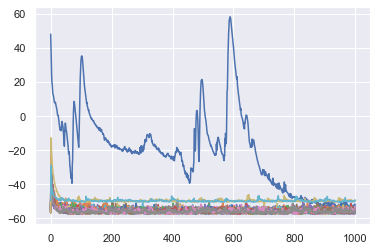

In [16]:
df_pert = pd.DataFrame({})
iters = 1000
all_dx = np.zeros((30,XB.shape[1]))
for j in range(30):
    Input_start = torch.nn.Parameter(dX, requires_grad = True)
    Input_start.retain_grad()
    optimizer = torch.optim.Adam([Input_start],lr= 0.1,weight_decay=0)
    torch.autograd.set_detect_anomaly(True)
    loss_all = []
    exp_var_all = []
    for i in range(iters):
        optimizer.zero_grad()
        Xstar = XB_start + Input_start
        X = torch.concat((XB,Xstar),0)
        U,S,V = torch.svd(X)
        
        w1 = V.T.norm(p=2, dim=1, keepdim=True)
        w2 = W_tot.T.norm(p=2, dim=1, keepdim=True)
        cosineLoss = torch.mm(V.t(), W_tot) / (w1 * w2.t()).clamp(min=1e-6)
        cosineLoss = torch.abs(cosineLoss)
        
        loss = -torch.mean(cosineLoss[np.arange(0,V.shape[1]),torch.argmax(cosineLoss,1)])
        loss = loss - 100. * torch.min(cosineLoss[np.arange(0,V.shape[1]),torch.argmax(cosineLoss,1)])
        loss = loss + 1e-2 * torch.sum(torch.abs(Input_start))

        loss.backward()
        optimizer.step()
        
        loss_all.append(loss.item())
        if i % 200 == 0 :
            outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
            outString += ', loss={:.4f}'.format(loss.item())
            print(outString)
    outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
    outString += ', loss={:.4f}'.format(loss.item())
    print(outString)
    print(cosineLoss[np.arange(0,V.shape[1]),torch.argmax(cosineLoss,1)].detach().cpu().numpy())
    print(cosineLoss[np.arange(0,V.shape[1]),torch.argmax(cosineLoss,1)].detach().cpu().numpy().min())
    plt.plot(range(iters),loss_all)
    all_dx[j,:] = Input_start.detach().cpu().numpy()
    j = j +1
pert_dx = pd.DataFrame(np.mean(all_dx,0)).T
pert_dx.columns = X_B.columns.values
pert_dx_std = pd.DataFrame(np.std(all_dx,0)).T
pert_dx_std.columns = X_B.columns.values
df_pert = df_pert.append(pert_dx)

In [17]:
# df_fatty.index = [i for i in range(XB_fatty.shape[0])]
df_pert.index = [i for i in range(XB_start.shape[0])]

In [18]:
df_pert

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,DDX51,YBX2,NANOS3,ISLR,CHEK2P5,TMEM95,C1R,OR4F4,PRKACA,GOLGA6L2
0,19.561236,34.600247,37.937096,-5.525124,-8.851924,-2.089139,9.073436,0.504495,-0.023016,4.693576,...,0.078652,-0.003828,-0.01302,-0.053566,0.0,0.006022,0.02448,-0.000585,-0.012167,-0.002036


(array([3.0000e+00, 1.0000e+01, 2.5972e+04, 1.1000e+01, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-12.76861998,  -7.69804836,  -2.62747674,   2.44309488,
          7.5136665 ,  12.58423812,  17.65480974,  22.72538136,
         27.79595297,  32.86652459,  37.93709621]),
 <BarContainer object of 10 artists>)

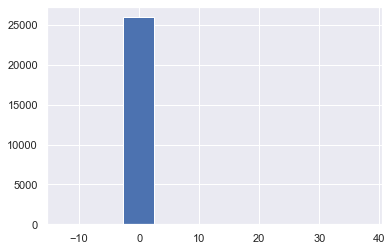

In [19]:
plt.hist(pert_dx.values.squeeze())

(array([2.5839e+04, 1.4200e+02, 7.0000e+00, 3.0000e+00, 4.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.        , 0.17481402, 0.34962804, 0.52444206, 0.69925609,
        0.87407011, 1.04888413, 1.22369815, 1.39851217, 1.57332619,
        1.74814022]),
 <BarContainer object of 10 artists>)

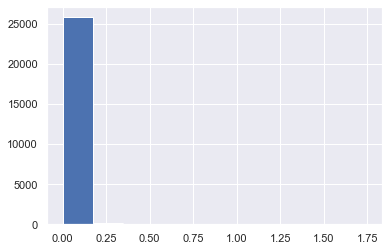

In [20]:
plt.hist(pert_dx_std.values.squeeze())

In [21]:
df_pert.to_csv('../results/optimized_mps/df_pert_lean_extra_govaere_kostrzewski.csv')

(array([2.84904141e-05, 0.00000000e+00, 2.84904141e-05, 4.27356135e-05,
        1.70942454e-04, 3.46243941e-01, 2.36327964e-02, 1.28206852e-04,
        4.27356060e-05, 1.42452070e-05, 1.42452070e-05, 1.42452070e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.84904141e-05]),
 array([-16.014687  , -13.314827  , -10.614966  ,  -7.915107  ,
         -5.2152467 ,  -2.5153866 ,   0.18447343,   2.8843334 ,
          5.584193  ,   8.284054  ,  10.983913  ,  13.683773  ,
         16.383633  ,  19.083494  ,  21.783354  ,  24.483213  ,
         27.183073  ,  29.882933  ,  32.582794  ,  35.282654  ,
         37.982513  ], dtype=float32),
 <BarContainer object of 20 artists>)

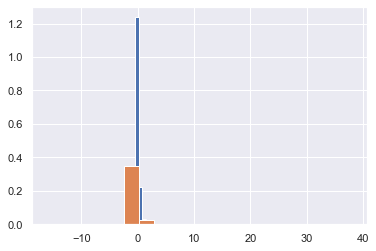

In [22]:
plt.hist(XB.detach().cpu().numpy().flatten(),20,density=True)
plt.hist(Xstar.detach().cpu().numpy().flatten(),20,density=True)

(array([1.51699107e-05, 3.03398213e-05, 7.58495533e-05, 7.58495533e-05,
        1.43203957e-02, 3.79672524e-01, 1.36529196e-04, 3.03398213e-05,
        3.03398213e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.51699107e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.51699107e-05, 1.51699107e-05]),
 array([-12.76861998, -10.23333417,  -7.69804836,  -5.16276255,
         -2.62747674,  -0.09219093,   2.44309488,   4.97838069,
          7.5136665 ,  10.04895231,  12.58423812,  15.11952393,
         17.65480974,  20.19009555,  22.72538136,  25.26066717,
         27.79595297,  30.33123878,  32.86652459,  35.4018104 ,
         37.93709621]),
 <BarContainer object of 20 artists>)

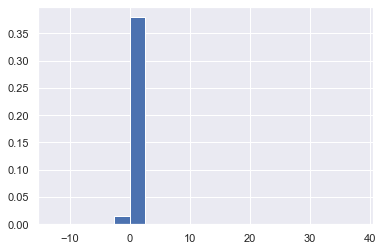

In [23]:
plt.hist(df_pert.values.flatten(),20,density=True)

## Using dX find new PC most similar to extra LV